# 07MIAR_Proyecto_Programación - Plant Seedlings Classification

## 0. Librerías

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.color import rgb2hsv
import json
import pandas as pd
from tensorflow.keras import Sequential
from keras.models import Model
from keras.layers import Dense, MaxPooling2D, BatchNormalization, Dropout, Conv2D, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing import image
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from keras import regularizers
from keras.optimizers import Adam

## 1. Lectura de los datos

### 1.1. Conexión remota con Google Drive

In [ ]:
# Conexión remota con Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1.2. Establecer ruta directa al directorio y lectura de datos

In [ ]:
# Establecimiento de una ruta absoluta al directorio de Google Drive
BASE_FOLDER = "/content/drive/MyDrive/BASE_FOLDER/"
DATASET = BASE_FOLDER + "my_dataset/ohe_data_train_resize_224.h5"

In [ ]:
# Lectura del dataset
df = pd.read_hdf(DATASET,key='data')

## 2. Red Neuronal Convolucional GMaster

### 2.1. Función para crear la red neuronal

In [ ]:
# Función para crear la red neuronal
def make_model():
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding='same',
                     input_shape=(224, 224, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(12, activation='softmax'))

    return model

def model_kaggle():
  model = Sequential()

  model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(224, 224, 3), activation='relu'))
  model.add(BatchNormalization(axis=3))
  model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(BatchNormalization(axis=3))
  model.add(Dropout(0.1))

  model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
  model.add(BatchNormalization(axis=3))
  model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(BatchNormalization(axis=3))
  model.add(Dropout(0.1))

  model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
  model.add(BatchNormalization(axis=3))
  model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(BatchNormalization(axis=3))
  model.add(Dropout(0.1))

  model.add(Flatten())

  model.add(Dense(256, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(256, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(12, activation='softmax'))

  return model

### 2.2. Análisis de la red neuronal

In [ ]:
# Guardar el modelo en una variable
model = make_model()

# Visualización de las capas de la red neuronal
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      4864      
                                                                 
 batch_normalization (Batch  (None, 224, 224, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      102464    
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 64)      256       
 chNormalization)                                                
                                                        

## 3. Prepocesado de datos.

In [ ]:
# 'X' contiene las imágenes e 'y' contiene las etiquetas de las imágenes
X = np.array(df['imagen'].tolist())   # Convertir X a un arreglo NumPy
y = df.iloc[:, 1:]  # Selecciona todas las columnas excepto la primera (X)

# Dividir los datos en conjuntos de entrenamiento y prueba en un 20% del total y con una semilla de aleatoriedad constante
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Análisis de las dimensiones de los datos y etiquetas
print("Dimensiones de 'X_train':", X_train.shape)
print("Dimensiones de 'X_test':", X_test.shape)
print("Dimensiones de 'y_train':", y_train.shape)
print("Dimensiones de 'y_test':", y_test.shape)

Dimensiones de 'X_train': (3800, 224, 224, 3)
Dimensiones de 'X_test': (950, 224, 224, 3)
Dimensiones de 'y_train': (3800, 12)
Dimensiones de 'y_test': (950, 12)


## 4. Hiperparámetros y entrenamiento de la red neuronal

### 4.1. Hiperparámetros

In [ ]:
# Hiperparámetros
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 0.01 * 0.9**x)   # Reduce el learning rate según avanza el entrenamiento por cada época
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15)   # Detiene el entrenamiento cuando se haya repetido el val_accuracy un número determinado de veces durante el entrenamiento (evita el overfitting)
epochs = 50   # Número de épocas
validation_split = 0.2    # Partición de los datos para validación
batch_size = 32   # Tamaño del lote de entrenamiento

### 4.2. Entrenamiento del modelo

In [ ]:
# Entrenamiento
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("[INFO] Entrenando Red Neuronal...")
history = model.fit(X_train, y_train, epochs=epochs, callbacks=[reduce_lr],
                    validation_split=validation_split, batch_size=batch_size)

[INFO] Entrenando Red Neuronal...
Epoch 1/50
95/95 [==============================] - 24s 123ms/step - loss: 2.6116 - accuracy: 0.3546 - val_loss: 115.0568 - val_accuracy: 0.0421 - lr: 0.0100
Epoch 2/50
95/95 [==============================] - 10s 107ms/step - loss: 1.5332 - accuracy: 0.5615 - val_loss: 3.4836 - val_accuracy: 0.3855 - lr: 0.0090
Epoch 3/50
95/95 [==============================] - 10s 107ms/step - loss: 1.1346 - accuracy: 0.6500 - val_loss: 7.3579 - val_accuracy: 0.2500 - lr: 0.0081
Epoch 4/50
95/95 [==============================] - 10s 107ms/step - loss: 0.9096 - accuracy: 0.7151 - val_loss: 3.3633 - val_accuracy: 0.3605 - lr: 0.0073
Epoch 5/50
95/95 [==============================] - 10s 107ms/step - loss: 0.7062 - accuracy: 0.7625 - val_loss: 2.4715 - val_accuracy: 0.5092 - lr: 0.0066
Epoch 6/50
95/95 [==============================] - 10s 107ms/step - loss: 0.6026 - accuracy: 0.7839 - val_loss: 1.5621 - val_accuracy: 0.6671 - lr: 0.0059
Epoch 7/50
95/95 [==========

## 5. Evaluación del modelo

### 5.1. Análisis de 'test loss' y 'test accuracy'

In [ ]:
# 'Test loss' y 'test accuracy'
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

30/30 [==============================] - 2s 52ms/step - loss: 0.6560 - accuracy: 0.8663
Test loss: 0.6559915542602539
Test accuracy: 0.8663157820701599


### 5.2. Representación gráfica

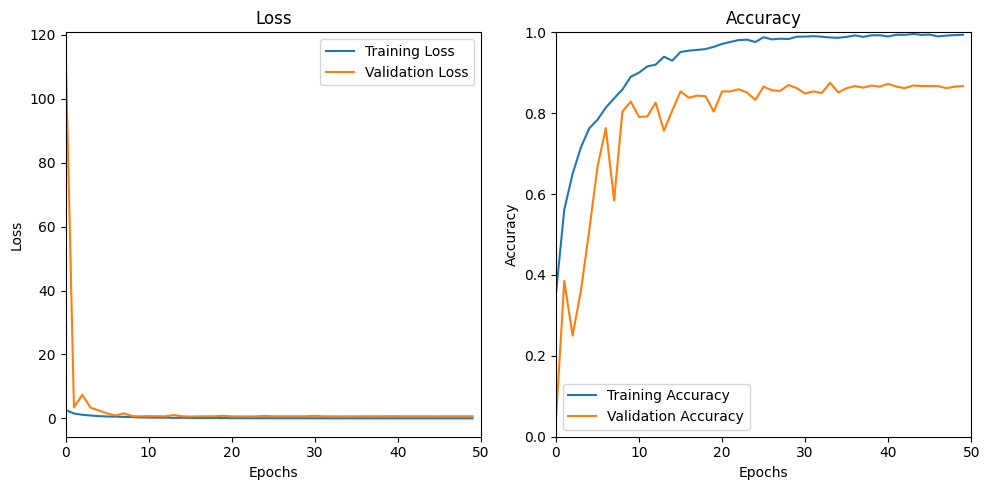

In [ ]:
def plot_learning_curves(history):
    plt.figure(figsize=(10, 5))

    # Plot de pérdida
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim(0, len(history.history['loss']))  # Establece límites para el eje x
    plt.legend()

    # Plot de precisión
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)  # Establece límites para el eje y
    plt.xlim(0, len(history.history['accuracy']))  # Establece límites para el eje x
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)

### 5.3. Matriz de confusión

30/30 [==============================] - 1s 18ms/step


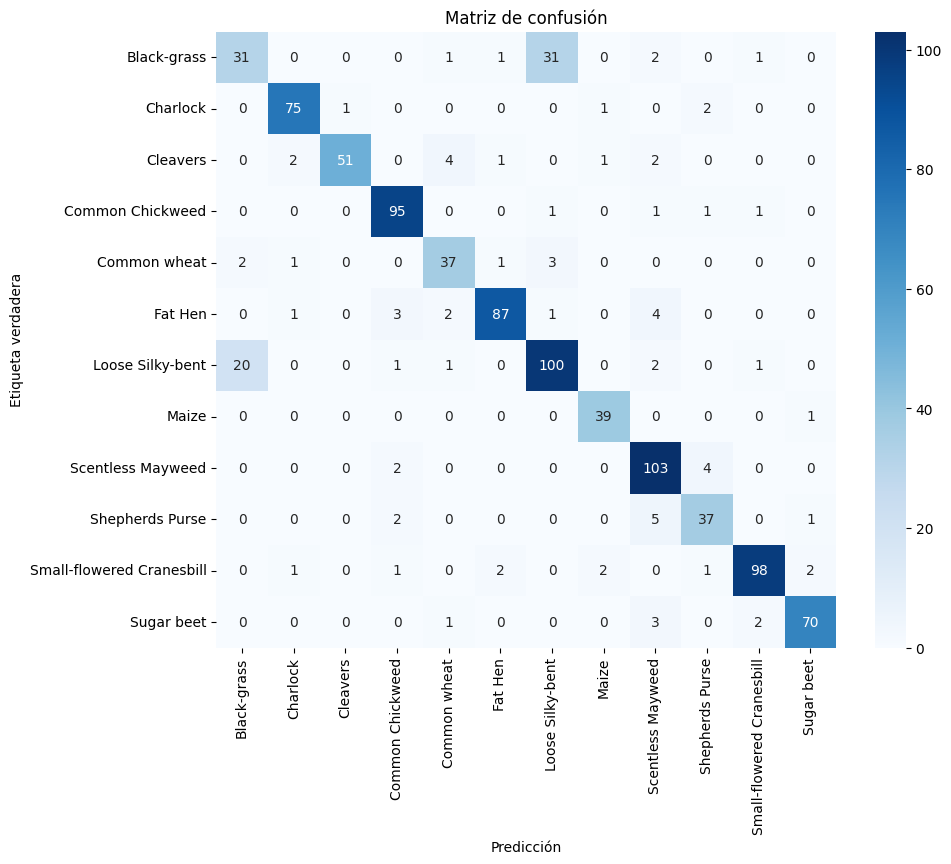

In [ ]:
# Obtener predicciones del conjunto de prueba
Y_pred = model.predict(X_test)

# Convertir las predicciones de las clases en etiquetas
y_pred_classes = np.argmax(Y_pred, axis=1)
y_true = np.argmax(y_test.values, axis=1)

# Calcular la matriz de confusión
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
clases = [
    "Black-grass",
    "Charlock",
    "Cleavers",
    "Common Chickweed",
    "Common wheat",
    "Fat Hen",
    "Loose Silky-bent",
    "Maize",
    "Scentless Mayweed",
    "Shepherds Purse",
    "Small-flowered Cranesbill",
    "Sugar beet"
]
# Visualizar la matriz de confusión
def confusion_matrix_plot(confusion_mtx, clases):
  plt.figure(figsize=(10, 8))
  sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=clases, yticklabels=clases)
  plt.xlabel('Predicción')
  plt.ylabel('Etiqueta verdadera')
  plt.title('Matriz de confusión')
  plt.show()

confusion_matrix_plot(confusion_mtx=confusion_mtx, clases=clases)

In [ ]:
model.save(BASE_FOLDER + "/models/GMaster/modelo_GMaster_86.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Reentreno de la red neuronal
epochs = 50
validation_split = 0.3

print("[INFO] Entrenando Red Neuronal...")
history = model.fit(X_train, y_train, epochs=epochs, callbacks=[reduce_lr],
                    validation_split=validation_split, batch_size=batch_size)

[INFO] Entrenando Red Neuronal...
Epoch 1/50
84/84 [==============================] - 12s 134ms/step - loss: 1.9388 - accuracy: 0.5282 - val_loss: 39.8140 - val_accuracy: 0.2868 - lr: 0.0100
Epoch 2/50
84/84 [==============================] - 9s 110ms/step - loss: 1.0958 - accuracy: 0.6575 - val_loss: 9.1176 - val_accuracy: 0.2184 - lr: 0.0090
Epoch 3/50
84/84 [==============================] - 9s 110ms/step - loss: 0.7631 - accuracy: 0.7530 - val_loss: 1.2287 - val_accuracy: 0.6719 - lr: 0.0081
Epoch 4/50
84/84 [==============================] - 9s 110ms/step - loss: 0.6244 - accuracy: 0.7891 - val_loss: 0.8145 - val_accuracy: 0.7509 - lr: 0.0073
Epoch 5/50
84/84 [==============================] - 9s 110ms/step - loss: 0.5760 - accuracy: 0.8049 - val_loss: 0.7399 - val_accuracy: 0.7500 - lr: 0.0066
Epoch 6/50
84/84 [==============================] - 9s 112ms/step - loss: 0.4104 - accuracy: 0.8575 - val_loss: 0.8820 - val_accuracy: 0.7640 - lr: 0.0059
Epoch 7/50
84/84 [================

In [ ]:
# 'Test loss' y 'test accuracy'
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

30/30 [==============================] - 1s 20ms/step - loss: 0.6248 - accuracy: 0.8411
Test loss: 0.6247930526733398
Test accuracy: 0.8410526514053345


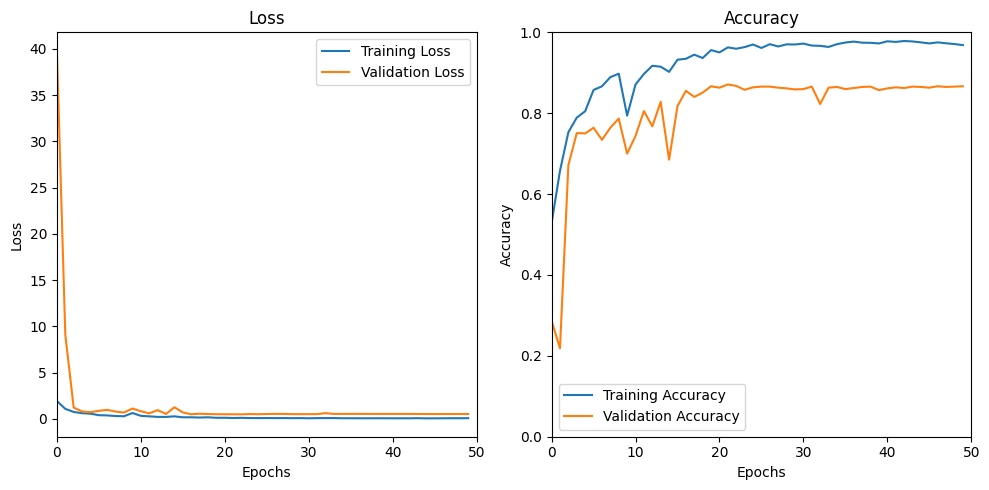

In [ ]:
# Representación gráfica de las curvas
plot_learning_curves(history)

30/30 [==============================] - 1s 18ms/step


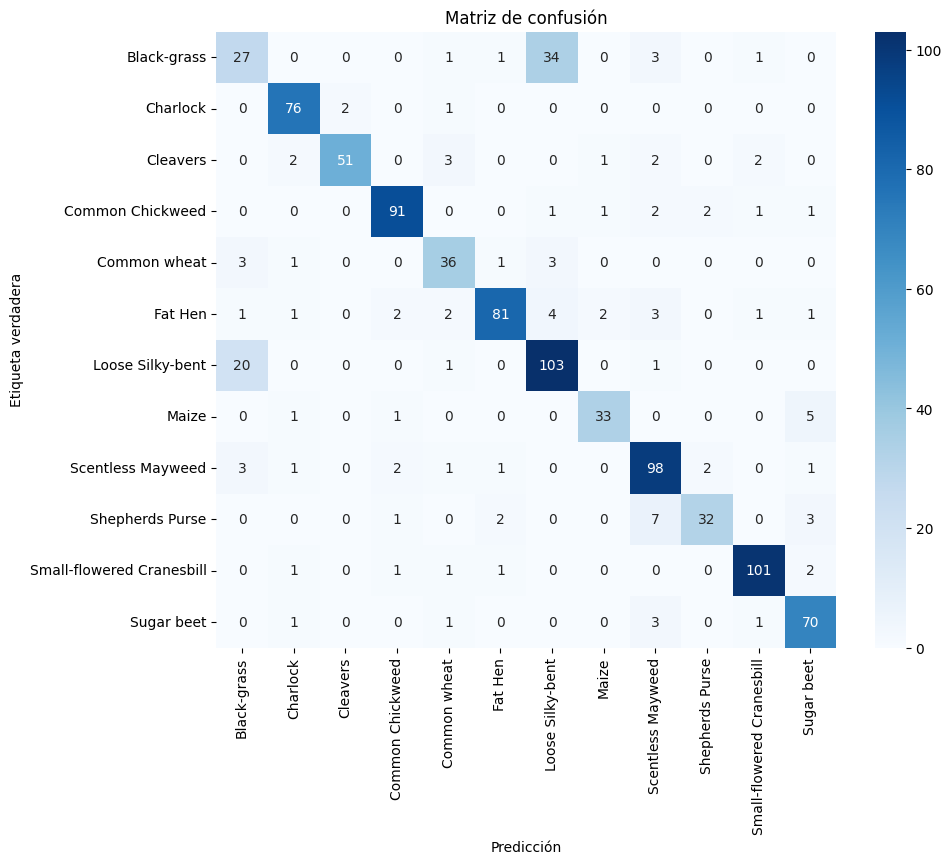

In [ ]:
# Obtener predicciones del conjunto de prueba
Y_pred = model.predict(X_test)

# Convertir las predicciones de las clases en etiquetas
y_pred_classes = np.argmax(Y_pred, axis=1)
y_true = np.argmax(y_test.values, axis=1)

# Calcular la matriz de confusión
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Visualizar la matriz de confusión
confusion_matrix_plot(confusion_mtx=confusion_mtx, clases=clases)